# Time-averaged projection example notebook

This notebook demonstrates the abilities of image projection enhancement as discussed in [Our time-averaged projection paper](https://www.overleaf.com/project/5f101200a6465100015789fa). This code demonstates the use of a transmission matrix and multiple patterns of a spatial light modulator to project images through a scattering medium with a high fidelity.

## What is included in this notebook

- Time-averaged projection using multiple patterns on a spatial light modulator
- The full forward model as discussed in the paper, including an efficient way to upsample the distal end
- Instead of an actual transmission matrix, a transmission matrix consisting of random numbers is employed.


# What is not in this notebook
In order to keep the code to a manageable size, the following things are not included. 

- Our experiments were performed with a DMD. The code to generate a DMD pattern based on the resulting phase profiles is not included. It can be found in [this paper](https://onlinelibrary.wiley.com/doi/abs/10.1002/andp.201500111?cookieSet=1) by Ren et al.
- Instead of structural similarity, the least-squared error metric is used


In [ ]:
# import the libraries that we will need
# visualisation
%matplotlib inline
from IPython.display import display_html
from skimage.transform import resize, downscale_local_mean
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm # progress bar
from mpl_toolkits import axes_grid1
from IPython.display import clear_output

# numerical processing
import numpy as np
from skimage.metrics import structural_similarity as ssim
# I/O
import imageio

# Optimization library
import jax
from jax import random
from jax import numpy as jnp

from jax.experimental import optimizers


In [ ]:
!pip install qrcode
import qrcode

# Simulation settings

In [ ]:
ndist = 64 # number of pixels on the distal end of the fiber
nprox = 48 # number of pixels on the proximal end
upsampling_distal = 2 # how many times to upsample on the distal end (aka number of pixels of the target = ndist * upsampling_distal)

npix_slm = 128 # number of pixels per side of the SLM

# random-number generator seed
seed = 1
key = random.PRNGKey(seed)

DTYPE=np.float32

In [ ]:
# make sure the the graphics card is employed. If no graphics card shows up, click on Runtime -> Change runtime type
!nvidia-smi 

Wed May 19 12:36:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    34W / 250W |  14679MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# TM loader

In [ ]:

def make_TM(key, ndist=ndist):
    """ 
    Create a pseudo-random transmission matrix that will serve as a simulation to our optical system. Feel free to replace with your own data.

    The transmission matrix is roughly normalized in such a way that the transmitted power is around one. More careful normalization will be done later on
    """
    
    ndist_half = ndist
    key, key_real, key_imag = random.split(key, 3)
    T = 1j*random.normal(key_imag, (ndist**2, nprox**2))
    T = T + random.normal(key_real, (ndist**2, nprox**2))
    # make the transmitted power kind of one
    P = np.mean(np.real(T*T.conj()), axis=1)
    T = T/np.sqrt(P.mean()) *np.sqrt(128)#* ndist * 3
    return T.astype(np.complex64) , key
    


# Forward model specification

In [ ]:
def time_average(intensities: jnp.ndarray) -> jnp.ndarray:
    """
    Compute the time-averaging operation. Equation (2) of the paper.

    Parameters:
        intensities: Input intensities. Shape: [npat, pixels]
    """
    return intensities.mean(axis=0)

def Ein_to_Eout(Ein: jnp.ndarray, TM: jnp.ndarray) -> jnp.ndarray:
    """
    Compute the output field, given a transmission matrix and a set of input fields.

    In order to make sure that the first index of both input fields (Ein) and output fields corresponds to the time axis,
    but to be able to process more than one pattern at a time, 
    we have to swap the order in which the matrix multiplication is performed.

    Equation (3) of the paper

    Parameters:
        Ein: Incident field, complex. Shape: [npat, nprox**2]
        TM: Transmission matrix, complex. Shape: [ndist**2, nprox**2]

    Returns:
        Eout: Output field. Shape: [npat, ndist**2]
    """
    # Equivalent would be ..
    # Eout_T = TM@Ein.T / Ein.shape[1]
    # return Eout_T.T

    # .. but more convenient
    Eout = Ein@TM.T
    return Eout
    

def Ein_to_Iout(Ein: jnp.ndarray, TM: jnp.ndarray, image_with_target_size: jnp.ndarray) -> jnp.ndarray:
    """
    Compute the output intensity, given an input field.

    Equation (4) of the paper.

    Parameters:
        Ein: Incident field, complex. Shape: [npat, nprox**2]
        TM: Transmission matrix, complex. Shape: [ndist**2, nprox**2]

    """
    Eout = Ein_to_Eout(Ein, TM)
    # Scale the intensity afterwards such that the transmitted intensity is roughly maintained
    normalization_factor = Eout.shape[-1] / image_with_target_size.shape[-1]**2
    Eout = upsample_field(Eout, image_with_target_size)
    Iout = abs(Eout)**2 / normalization_factor**2
    return Iout



def SLM_to_Ein(phi: jnp.ndarray, S: jnp.ndarray, Admd: jnp.ndarray=1, nprox=nprox) -> jnp.ndarray:
    """ 
    Compute the electric field at the input facet of the SLM.

    Equation (7) of the paper.

    Parameters:
        phi: Phase retardation. Shape: [npat_per_frame, npix_slm**2]
        S: indices to extract
        Admd: Amplitude incident on the DMD.

    
    Returns:
        The electric field on the input facet of the TM, of size [npat_per_frame, nprox**2]

    Notes:
        In the real implementation, the number of pixels on the SLM is larger than the number of pixels that are scanned and only a subset of the farfield area
        is used.

    """
    # reshape the fields into a useful shape the fourier transforms
    npat_per_frame, npix_slm_sq = phi.shape
    npix_slm = np.sqrt(npix_slm_sq).astype(int)

    esw_slm = jnp.exp(1j*phi).reshape(npat_per_frame, npix_slm, npix_slm)
    # compute the farfield of the SLM
    e_in = jnp.fft.fftshift(jnp.fft.fft2(jnp.fft.ifftshift(esw_slm)))
    # extract only the relevant bit
    # in this example implementation this is hard-coded to start at (10,10), but 
    # it is not a strict requirement
    e_in = jax.lax.dynamic_slice(e_in, (0, 10, 10), (npat_per_frame, nprox, nprox))
    # in principle this would be the equivalent but it cannot be compiled
    # e_in = e_in[:,10:10+nprox, 10:10+nprox]
    return e_in.reshape(npat_per_frame, nprox*nprox)


@jax.jit
def upsample_field(Eout: jnp.ndarray, image_with_output_size):
    """
    Upsample a field in fourier space.

    Parameters:
        Eout: Output electric field. Shape: [npat, ndist**2]
        image_with_output_size: Image with the required size. Shape: [npat, new_size, new_size]

    Returns:
        Eout_upsampled: Upsampled version of Eout. Shape: [npat, new_size**2]

    """
    npat, ndist_sq = Eout.shape
    ndist = np.sqrt(ndist_sq).astype(int)
    ndist_new = image_with_output_size.shape[-1]
    if ndist == ndist_new:
        print('Returning the original one')
        return Eout
    Eout_3d = Eout.reshape(npat, ndist, ndist)
    Eout_ff = jnp.fft.fftshift(jnp.fft.fft2(jnp.fft.ifftshift(Eout_3d)))
    # pad to the right size
    npad_before = ndist_new//2 - ndist//2
    npad_after = ndist_new - npad_before - ndist
    Ein_ff_padded = jnp.pad(Eout_ff, ((0,0), (npad_before, npad_after), (npad_before, npad_after)))
    Ein_padded = jnp.fft.fftshift(jnp.fft.ifft2(jnp.fft.ifftshift(Ein_ff_padded)))
    return Ein_padded.reshape(npat, ndist_new**2)


def forward_model(phi, TM, Admd, image_with_target_size):
    """
    Calculate the full forward model, from input phase to an intensity image with the right number of pixels.

    """
    nprox = np.sqrt(TM.shape[-1]).astype(int)
    Ein = SLM_to_Ein(phi, Admd, nprox)
    Iout = Ein_to_Iout(Ein, TM, image_with_target_size)
    Iout_TA = time_average(Iout)
    # a scaling is applied to normalize the gradient
    return Iout_TA.reshape(*image_with_target_size.shape[-2:]) / phi.shape[-1]

The slowest run took 1051.38 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 1.08 ms per loop


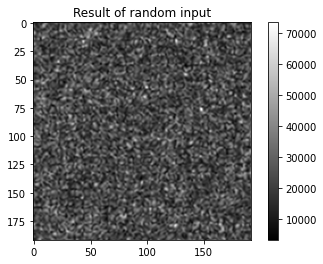

In [ ]:
# test it
phi = jnp.array(np.random.rand(10, npix_slm**2), dtype=DTYPE)
TM, key = make_TM(key, ndist=ndist)
zeros_target_shape = np.zeros((10, 3*ndist, 3*ndist))
%timeit jax.jit(forward_model)(phi, TM, 1,  zeros_target_shape).block_until_ready()
plt.imshow(forward_model(phi, TM, 1.0, zeros_target_shape), cmap='gray')
plt.title('Result of random input')
plt.colorbar()

(172, 172) 192


Text(0.5, 1.0, 'Target intensity')

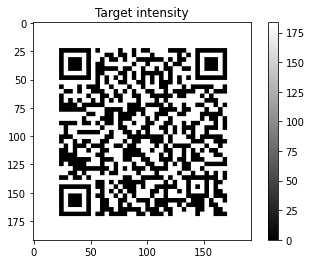

In [ ]:
# create a target image

def make_target(npix=ndist*2):
    ss = slice(230-npix, 230-npix+2*npix,2)
    target_image = imageio.imread('imageio:camera.png')[ss,ss]#[100:100+ndist*2:2,170:170+2*ndist:2]
    return target_image / target_image.mean() * 128



def make_QR_tinyurl(data="TAP Image demonstration, available at\n https://tinyurl.com/dp3d2faw",
                    ndist=ndist*4):
    qr = qrcode.QRCode(
        version=1,
       error_correction=qrcode.constants.ERROR_CORRECT_M,
        box_size=4,
        border=3,
    )

    qr.add_data(data=data)
    img = np.array(qr.make_image()).astype(np.float32)
    print(img.shape, ndist)
    if img.shape[-1] < ndist:
        img = np.pad(img, (ndist-img.shape[-1])//2+1, mode='constant', constant_values=1)
    img = img[:ndist, :ndist]
#    img = resize(img, [ndist, ndist],anti_aliasing=False).astype(np.float32)
    img = img > img.mean()
    return img.astype(np.float32) / img.mean() * 128

I_tg = make_QR_tinyurl(ndist=ndist*3)#make_target(npix=3*ndist)
#I_tg = I_tg / I_tg.sum()
plt.imshow(I_tg, cmap='gray', interpolation=None)
plt.colorbar()
plt.title('Target intensity')

## Normalization


Iteration 0 of 100, Power: 47.42643737792969. Ratio: 1.0
Iteration 10 of 100, Power: 107.6147232055664. Ratio: 2.269087314605713
Iteration 20 of 100, Power: 117.78067779541016. Ratio: 2.4834394454956055
Iteration 30 of 100, Power: 122.2704849243164. Ratio: 2.578108310699463
Iteration 40 of 100, Power: 124.57563018798828. Ratio: 2.6267127990722656
Iteration 50 of 100, Power: 125.86900329589844. Ratio: 2.6539840698242188
Iteration 60 of 100, Power: 126.654052734375. Ratio: 2.670536994934082
Iteration 70 of 100, Power: 127.17378997802734. Ratio: 2.6814959049224854
Iteration 80 of 100, Power: 127.53726196289062. Ratio: 2.689159631729126
Iteration 90 of 100, Power: 127.80311584472656. Ratio: 2.694765329360962



Iteration 0 of 100, Power: 47.52743911743164. Ratio: 1.0000001192092896
Iteration 10 of 100, Power: 107.60861206054688. Ratio: 2.264136791229248
Iteration 20 of 100, Power: 117.76161193847656. Ratio: 2.4777607917785645
Iteration 30 of 100, Power: 122.22664642333984. Ratio: 2.571707248687744
Iteration 40 of 100, Power: 124.5164794921875. Ratio: 2.6198863983154297
Iteration 50 of 100, Power: 125.79415130615234. Ratio: 2.6467690467834473
Iteration 60 of 100, Power: 126.58438110351562. Ratio: 2.663395881652832
Iteration 70 of 100, Power: 127.08921813964844. Ratio: 2.674017906188965
Iteration 80 of 100, Power: 127.44770050048828. Ratio: 2.681560516357422
Iteration 90 of 100, Power: 127.73551177978516. Ratio: 2.6876163482666016



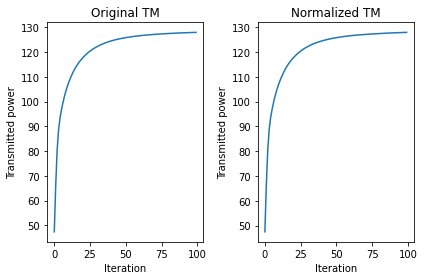

In [ ]:
# normalization
# To have a reasonable estimate of the total power than we have to normalize the 
# transmission matrix to, optimize the total amount of power transmitted through the optical system.
def cost_power(phi_in, TM, I_tg):
    I_fw = forward_model(phi_in, TM, 1.0, I_tg)
    P_fw = I_fw.mean()
    return -P_fw


def optimize_power(npat_per_frame, TM, image_with_target_shape, nits=100):
    op_init, op_update, op_get = optimizers.adam(5e-1)
    phi_0 = jnp.array(np.random.normal(size=(npat_per_frame, TM.shape[1])))
    
    state = op_init(phi_0)

    @jax.jit
    def update(i, state, TM, image_with_target_shape):
        phi = op_get(state)
        val, grad = jax.value_and_grad(cost_power)(phi, TM, image_with_target_shape)
        return -val, op_update(i, grad, state)

    vals = []

    for i in tqdm(range(nits)):
        val, state = update(i, state, TM, image_with_target_shape)
        if i == 0:
            v0 = val
        if i % 10 == 0:
            print(f'Iteration {i} of {nits}, Power: {val}. Ratio: {val /v0}')
        vals.append(val)

    plt.plot(vals)
    plt.xlabel('Iteration')
    plt.ylabel('Transmitted power')
    return vals[-1]


plt.subplot(121)
plt.title('Original TM')
maxpower = optimize_power(500, TM, I_tg)

plt.subplot(122)
plt.title('Normalized TM')
# We use the transmitted power to normalize the transmission matrix. We scale the values such that the 
# averaged transmitted power is around 128 units, which was found to be a nice compromise between running into errors due to machine
# precision and having a gradient step that is too large.
TM = TM / np.sqrt(maxpower) * np.sqrt(128)
maxpower = optimize_power(50, TM, I_tg)
plt.tight_layout()

# Pattern optimization

Now, all the pre-work is done and we can start to optimize for our patterns.


In [ ]:

def loss_l2(I_fw, I_tg):
    """ Compare two images and return the l2 difference.
    
    In order to get a gradient that is numerically stable, the result is divided by with the number of pixels on the distal end 
    """
    diff = I_fw - I_tg
    return jnp.sum(diff**2)/I_tg.size 

In [ ]:
# use this for large transmission matrices, it saves RAM at the expense of computation speed
# @jax.remat

def costfunction(ph_in, I_tg, TM):
    """ Calculate the value of the loss function for a given set of input patterns and a given target intensity image.

    Also returns the predicted intensity.
    
    Parameters:
        ph_in: jax array of size [npat_per_frame, nprox**2]
            The input phase patterns
        I_tg: jax array of size [ndist, ndist]
            Target intensity distribution
        T: transmission matrix of size [ndist**2, nprox**2]


    """
    I_fw = forward_model(ph_in, TM, 1.0, I_tg)
    return loss_l2(I_fw, I_tg), I_fw
# Check that the gradient has values that are far away from the numerical precision. We try to normalize such that this is between 0.01 and 100.
print('Mean squared gradient update: ', abs(jax.grad(costfunction, has_aux=True)(phi, I_tg[::1,::1] , TM)[0]**2).mean())

Mean squared gradient update:  0.010328204


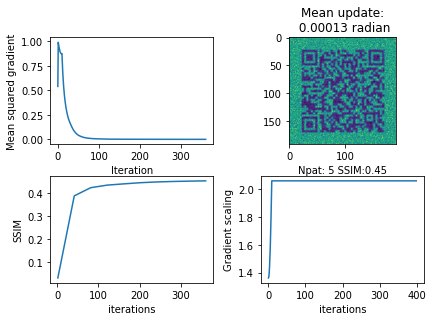

In [ ]:
def optimize_time_averaged_projection(n_pat_per_frame=10, I_tg=I_tg, TM=TM,
                                      n_its = 1500, fig=None, ax=None, number_of_frames_per_visualisation=10):
    
    # initialize the patterns
    p0 = np.random.random(size=(n_pat_per_frame, nprox* nprox))*4
    
    # make sure the total intensity is matched. When it is set a little bit less than the maximum obtainable power, we get much better results.
    # This has to to with the more or less random nature of our transmission matrix, in case of a fiber it is not required.
    I_tg = I_tg / 1.12
    I_tg_jax = jnp.asarray(I_tg) 

    TM = jnp.asarray(TM)


    # Generate the things that we need for the optimizer.
    # See jax tutorials for information on how to use the optimizers
    op_init, op_update, op_get = optimizers.adam(step_size=1e-1)


    @jax.jit#@jax.partial(jax.jit, static_argnums=4)
    def optimization_step(i, state, I_tg, TM, scaling):
        """
        Perform a single step of the optimization. This function takes the current
        estimate of the phases (wrapped in state), 
        the target intensity distribution (I_tg) and the transmission matrix TM
        and returns a new state that (hopefully) improves the resulting image.

        The value of the gradient for the update step is scaled by scaling. 
        This can be used when the gradient turns out to be too big.
        """
        # get the current estimate of the SLM
        phase = op_get(state)
        # compute the value, the predicted intensity and the gradient of our data term
        (val, I_fw), grad = jax.value_and_grad(costfunction, has_aux=True)(phase, I_tg, TM)
        # scale the gradient
        grad = grad * scaling
        # compute the typical update for every pixel
        avg_update = jnp.mean(jnp.real(grad*grad.conj()))
        # return the averaged update, predicted intensity and a new estimate of the patterns
        return avg_update, I_fw, op_update(i, grad, state)


    state = op_init(jnp.array(p0))

    # We will keep track of the following things:
    iterations_ssim, ssims = [] , [] # SSIM for every frame that is displayed
    
    # Mean squared gradient for every iteration
    grad_step = np.zeros(n_its)
    # The scaling that was employed
    scalings = 0*grad_step
    scaling = 1
    # at which interval to show the resulting image
    show_every = np.clip(n_its // number_of_frames_per_visualisation, 5, None)
    
    
    for i in tqdm(range(n_its)):
        # this is the optimization
        grad_step[i], I_fw, state = optimization_step(i, state, I_tg_jax, TM, scaling)

        # scale the gradient step size for the first few iterations
        if i < 10:
            # scale the gradient such that the mean averaged update is around 1 radian
            scaling =  scaling / np.sqrt(grad_step[i])
            scalings[i:] = scaling

        # visualization
        if i % show_every == 1 and fig is not None:
            ssims.append(ssim(np.array(jax.device_get(I_fw)), I_tg, data_range=I_tg.max()))
            iterations_ssim.append(i)
            ax[0,0].cla()
            ax[0,0].plot(grad_step[:i])
            ax[0,0].set_ylabel('Mean squared gradient')
            ax[0,0].set_xlabel('Iteration')
            ax[0,1].cla()
            ax[0,1].imshow(I_fw)
            ax[0,1].set_xlabel(f'Npat: {n_pat_per_frame} SSIM:{ssims[-1]:.2g}')
            ax[0,1].set_title(f'Mean update:\n {grad_step[i]:.2g} radian')

            ax[1,0].cla()
            ax[1,0].plot(iterations_ssim, ssims)
            ax[1,0].set_xlabel('iterations')
            ax[1,0].set_ylabel('SSIM')

            ax[1,1].cla()
            ax[1,1].plot(scalings)
            ax[1,1].set_xlabel('iterations')
            ax[1,1].set_ylabel('Gradient scaling')
    return op_get(state), I_fw


fig, ax = plt.subplots(2,2)
fig.tight_layout()


optimize_time_averaged_projection(5, TM=TM, fig=fig, ax=ax, n_its=400, 
                                  );

# Show influence of number of patterns

Project the same scene using a varying number of patterns and show the influence on the projection fidelity

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5589: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


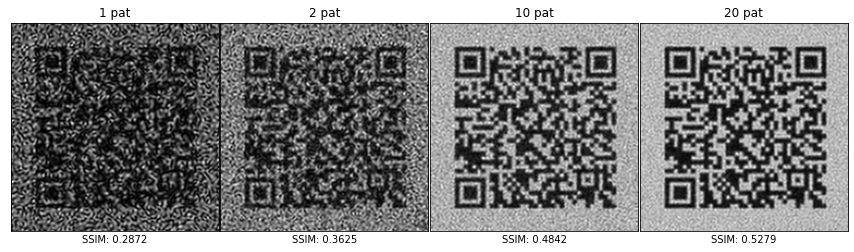

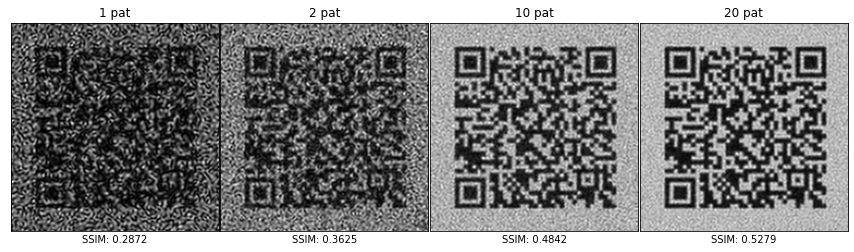

In [ ]:
target = I_tg / I_tg.mean() * 128

npats = [1,2,10,20]
fig = plt.figure(figsize=(15,8))
ax = axes_grid1.ImageGrid(fig,111, (1,len(npats)), label_mode='llc', )

for i, npat in enumerate(tqdm(npats, desc='npat per frame')):
    p_opt, I_opt = optimize_time_averaged_projection(npat, n_its=2000, I_tg=target)
    ax[i].imshow(I_opt, cmap='gray')
    ax[i].set_title(f'{npat} pat')
    ax[i].set_xlabel(f'SSIM: {ssim(I_opt, target, data_range=target.max() - target.min()):.4g}')
    ax[i].xaxis.set_ticks([])
    ax[i].yaxis.set_ticks([])
    
    #clear_output(wait=True)
display(fig)
